In [107]:
result=[]

当前预测的列            r
0  21.831501
1  21.832888
2  21.834280
3  21.835676
4  21.837076
训练集shape： (1459, 2, 10) (1459,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_60 (InputLayer)        (None, 2, 10)             0         
_________________________________________________________________
flatten_60 (Flatten)         (None, 20)                0         
_________________________________________________________________
dense_119 (Dense)            (None, 32)                672       
_________________________________________________________________
dense_120 (Dense)            (None, 1)                 33        
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________
Train on 1313 samples, validate on 146 samples
Epoch 1/50
 - 1s - loss: 0.0989 - acc: 0.0000e+00 - val_loss: 0.1176 - val_acc: 0.0068
Epoch 2/50
 - 0s - loss: 

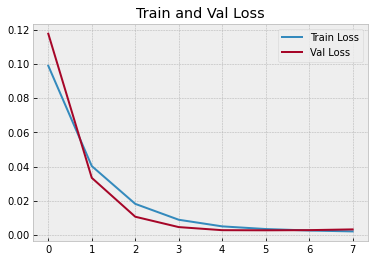

test dataset shape： (363, 2, 10) (363,)


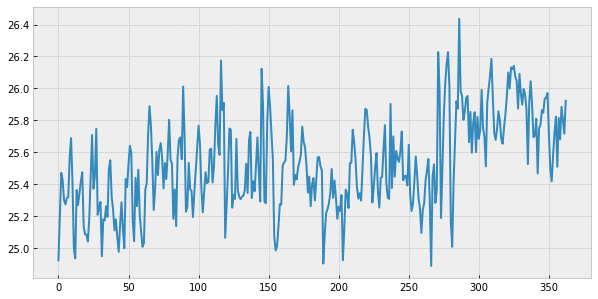

In [156]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from keras.layers import *
from keras.models import *
from keras.optimizers import Adam
from keras.models import load_model
import keras.backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
#plt.style.use('fivethirtyeight')
plt.style.use('bmh')
#plt.style.use('classic')

def deal_delay(data):
    #将数据集按滞后天数处理
    for factor_index in range(len(delay_factor)):
        temp_col_name=data.columns[factor_index]
        temp_factor=delay_factor[factor_index]
        if temp_factor==0:
            break
        data[temp_col_name]=np.hstack((np.zeros(temp_factor),data[temp_col_name].values[:-temp_factor]))
    return data

def data2lstm(train_x,train_y):
    #将数据从二维转化为三维
    feature_num = train_x.shape[1]
    data_length=train_x.shape[0]
    x=[]
    y=[]
    for index in range(data_length - window):
      x.append(train_x[index+1: index + window+1,:-1])
      #x.append(data[index: index + window,:]) 
      y.append(train_y[index +window ,-1])
    x = np.array(x)
    y= np.array(y) 
    return x,y

def read_data(choose):
    #读取数据
    data=pd.read_excel('总的数据集.xls',header=0)
    data=data.iloc[:,1:]
    data=deal_delay(data)
    train_x=data.iloc[:-test_num,:11]
    train_y=data.iloc[:-test_num,11+choose:11+choose+1]
    print('当前预测的列',train_y.head())
    real_train_y=data.iloc[:-test_num,10:11]
    test_x=data.iloc[-test_num:,:11]
    real_test_y=data.iloc[-test_num:,10:11]
    #根据原始数据集构建符合神经网络的数据集
    mm_x= MinMaxScaler()
    train_x= mm_x.fit_transform(train_x)
    mm_y= MinMaxScaler()
    train_y= mm_y.fit_transform(train_y)
    x_train,y_train=data2lstm(train_x,train_y)
    print('训练集shape：',x_train.shape,y_train.shape)
    return x_train,y_train,feature_num,test_x,real_test_y,mm_x,mm_y

def test_data(test_x,real_test_y,mm_x):
    #读取测试集
    test_x=mm_x.transform(test_x)
    real_test_y=real_test_y.values
    x_test,y_test=data2lstm(test_x,real_test_y)
    print('test dataset shape：',x_test.shape,y_test.shape)
    return  x_test,y_test

def cnn_lstm_model():
  #建立神经网络模型
  inputs=Input(shape=(window, feature_num))
  cnn1=Conv1D(filters = filters, kernel_size = kernel_size, activation = 'relu')(inputs)#卷积层
  cnn1=MaxPooling1D(pool_size = window)(cnn1)#池化层
  rnn=LSTM(rnn_units, activation='relu',return_sequences=True)(cnn1)#GRU
  dense=Dropout(dropout)(rnn)#droupout层
  outputs=Lambda(lambda x:K.squeeze(x, axis=1))(dense)
  outputs = Dense(1, activation='relu')(outputs)
  model = Model(inputs=inputs, outputs=outputs)
  model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
  model.summary()#展示模型结构
  return model

def bp_model():
  #建立神经网络模型
    inputs=Input(shape=(window, feature_num))
    inputs_pp=Flatten()(inputs)
    dense=Dense(dense_units,activation='relu')(inputs_pp)#全连接层
    outputs = Dense(1, activation='relu')(dense)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
    model.summary()#展示模型结构
    return model

def lstm_model():
  #建立神经网络模型
  inputs=Input(shape=(window, feature_num))
  rnn=LSTM(rnn_units, activation='relu',return_sequences=False)(inputs)#GRU
  dense=Dropout(dropout)(rnn)#droupout层
  #outputs=Lambda(lambda x:K.squeeze(x, axis=1))(dense)
  outputs = Dense(1, activation='relu')(dense)
  model = Model(inputs=inputs, outputs=outputs)
  model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
  model.summary()#展示模型结构
  return model

def gru_model():
  #建立神经网络模型
  inputs=Input(shape=(window, feature_num))
  rnn=GRU(rnn_units, activation='relu',return_sequences=True)(inputs)#GRU
  pooling = MaxPooling1D()(rnn)
  lam = Lambda(lambda x:K.squeeze(x, axis=1))(pooling)
  dense=Dropout(dropout)(lam)#droupout层
  #outputs=Lambda(lambda x:K.squeeze(x, axis=1))(dense)
  outputs = Dense(1, activation='relu')(dense)
  model = Model(inputs=inputs, outputs=outputs)
  model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
  model.summary()#展示模型结构
  return model

def train_model():  
  #保存最好的模型
  es = EarlyStopping(monitor='val_loss', patience=2)
  cp = ModelCheckpoint(filepath=save_model, monitor='val_loss', save_best_only=True)
  history = myModel.fit(x=x_train,
                        y=y_train,
                        batch_size=batch_size,
                        epochs=epoch,
                        verbose=2,callbacks=[es, cp],
                        validation_split=0.1)
  #迭代图像
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs_range = range(len(loss))
  plt.plot(epochs_range, loss, label='Train Loss')
  plt.plot(epochs_range, val_loss, label='Val Loss')
  plt.legend(loc='upper right')
  plt.title('Train and Val Loss')
  plt.show()
def test_model():
    x_test,y_test_real=test_data(test_x,real_test_y,mm_x)
    y_test_predict=myModel.predict(x_test)#预测结果
    y_test_predict=np.reshape(y_test_predict, (-1,1))  
    y_test_predict= mm_y.inverse_transform(y_test_predict)
    y_test_predict=y_test_predict[:,0]
    plt.figure(figsize=(10,5))
    plt.plot(y_test_predict)
    plt.show()    
    return y_test_predict

#设置参数
test_num=1827-1462#测试集数量
window=2#时间窗长度
rnn_units =16#rnn神经元个数
filters=32#cnn filter个数
kernel_size=1#cnn kernel个数
dense_units=32#dense层神经元个数
dropout = 0.1
epoch=50#迭代次数
batch_size=64#批处理数量
validation_split=.1#验证集比例
save_model='cnn_lstm.h5'#保存模型
choose=7#当前预测的标签0~7
delay_factor=[0,11,4,1,0,12]#滞后参数
#算法
x_train,y_train,feature_num,test_x,real_test_y,mm_x,mm_y=read_data(choose)#加载数据
myModel = bp_model()#建立模型
train_model()#模型训练
myModel.load_weights(save_model) # 加载最好的训练结果  
y_test_predict=test_model()#模型预测
#pd.DataFrame(y_test_predict).to_csv('result.csv')

In [123]:
result.append(y_test_predict)
result

[array([ 9.40983668e-02, -1.04465336e-01, -4.20801729e-01,  6.71795726e-01,
        -1.60100967e-01, -3.21041197e-01,  6.70020640e-01, -2.79332280e-01,
         8.90752196e-01,  1.56713164e+00, -6.43277839e-02, -1.64599168e+00,
        -9.29580927e-01, -9.30105865e-01, -1.28606617e+00, -4.31258410e-01,
         3.88882309e-01, -2.27245420e-01, -1.42465842e+00, -5.89156866e-01,
        -3.07697862e-01, -5.26484549e-01, -5.69248915e-01, -3.59406978e-01,
         1.09660780e+00,  1.11529984e-01,  9.97074544e-01, -3.04654628e-01,
         9.54723299e-01,  7.92254627e-01,  6.77903831e-01, -1.92518842e+00,
        -8.99229050e-01, -3.77895892e-01,  4.64340538e-01, -3.94212186e-01,
        -3.80543917e-01, -4.97387052e-01, -1.08274448e+00, -4.19578880e-01,
         3.12356412e-01,  7.51554209e-04, -2.00881672e+00, -2.43577409e+00,
        -1.37239802e+00, -1.33797705e+00, -1.52591383e-02,  1.24021447e+00,
        -3.16345990e-01,  3.06542546e-01, -3.38151664e-01,  5.38992345e-01,
        -2.5

(8, 363)


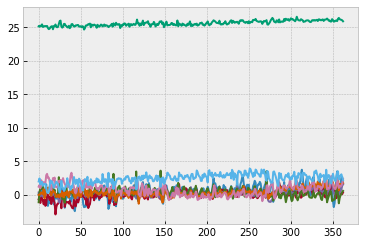

In [157]:
result=np.array(result)
print(result.shape)
plt.plot(result.T)
plt.show()
real_predict=result.sum(axis=0)
real_test_y=real_test_y['count'].values[-len(real_predict):]

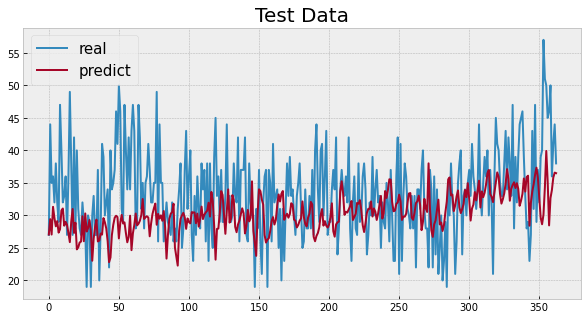

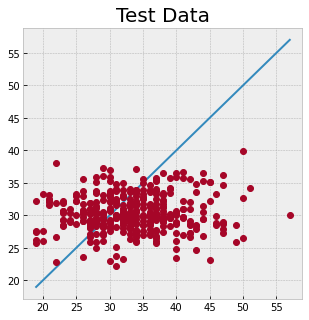

Test上的MAE/RMSE/MAPE
5.9742708547713015
7.66968648981605
17.51002099285991


In [158]:
def mape(y_true, y_pred):
    #评价指标MAPE
    record=[]
    for index in range(len(y_true)):
      if abs(y_true[index])>10:
        temp_mape=np.abs((y_pred[index] - y_true[index]) / y_true[index])
        record.append(temp_mape)
    return np.mean(record) * 100
def easy_result(y_train,y_train_predict,train_index):
    #进行反归一化
    #画图进行展示
    plt.figure(figsize=(10,5))
    plt.plot(y_train[:test_num])
    plt.plot(y_train_predict[:test_num])
    plt.legend(('real', 'predict'),fontsize='15')
    plt.title("%s Data"%train_index,fontsize='20') #添加标题
    plt.show()
    print('\n')
    plot_begin,plot_end=min(min(y_train),min(y_train_predict)),max(max(y_train),max(y_train_predict))
    plot_x=np.linspace(plot_begin,plot_end,10)
    plt.figure(figsize=(5,5))
    plt.plot(plot_x,plot_x)
    plt.plot(y_train,y_train_predict,'o')
    plt.title("%s Data"%train_index,fontsize='20') #添加标题
    plt.show()
    #输出结果
    print('%s上的MAE/RMSE/MAPE'%train_index)
    print(mean_absolute_error(y_train, y_train_predict))
    print(np.sqrt(mean_squared_error(y_train, y_train_predict) ))
    print(mape(y_train, y_train_predict) )
easy_result(real_test_y,real_predict,'Test')#输出评价指标
